Creative Commons CC BY 4.0 Lynd Bacon & Associates, Ltd. Not warranted to be suitable for any particular purpose. (You're on your own!)

# Naive Bayes Classifier

An algorithm that predicts target values by conditioning on the values of features, which are assumed to be conditionally independent.

Because of the features independence assumption, this method has also been called the _Idiot Bayes_ classifier. 

# Bayes Rule

You've seen this before:

\begin{align*}
\large
p(\theta|D)~=~\frac{p(D|\theta)p(\theta)}{p(D)}
\end{align*}  

Here, $\theta$ is one or more parameters we want to learn about.  In the Bayesian Classifier context, the parameters specify label probabilities.  D is "data," or information. $\theta$ can be a very long vector. That is the, posterior density on the LHS can be highly dimensional.

The term on the LHS is the posterior probability of $\theta$ conditional on D; it tells us about uncertainty about $\theta$.  The two quantities in the numerator on the RHS are referred to as the likelihood of the data given $\theta$, and the prior probability of $\theta$.  p(D) is often called the data density.  For a particular data set it's constant, so when estimating p($\theta$|D) it's ignored, and the version of the above that's used is:  

\begin{align*}
\large
p(\theta|D)~\propto~p(D|\theta)p(\theta)
\end{align*}

One way of looking at this theorem is that it is a _learning algorithm_:  
* p($\theta$) is what we know about parameters of interest before getting D.  
* p(D|$\theta$) is the likelihood of data we've observed given what we have believed about $\theta$.
* p($\theta$|D) is how we've "adjusted" what we believe about $\theta$ now that we've received D. 

p($\theta$|D) can be our "best guess" about p($\theta$) the next time we are about to get new D.  

<h1>The benefit of Bayes Classifier Idiocy</h1>

The benefit of the independence assumption as applied in these classifiers is that it greatly simplifies computation, and makes training much faster than it might otherwise be.  Use of the probability product rule, and simplification resulting from the the _conditional independence_ 

For example, in the context of binary features and a binary target, some outcome "O" and a set of binary indicators X<sub>i</sub>, the _joint posterior density_ can be calculated as:

\begin{align*}
\large
\text{p} (O,X_1, X_2, ... X_n) = \text{p}(O)\prod_{i=1}^{n} \text{p}(X_i\mid p(O))
\end{align*}

The posterior probability of 0, $p(0\mid X_1,.., X_n)$ can then be obtained by using the product rule.

<h1>Bayes Classifier Flavors</h1>

Defined mainly in terms of the type(s) of distributions assumed, and there are several.  In `scikit-learn`, the [naive Bayes Methods](https://scikit-learn.org/stable/modules/naive_bayes.html#naive-bayes) include:

* [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html#sklearn.naive_bayes.GaussianNB): Data likelihood assumed to be Gaussian.
* [BurnoulliNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.BernoulliNB.html#sklearn.naive_bayes.BernoulliNB): binary data.
* [MultinomialNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB) : features that are count data.

All three use _smoothing_ parameters to deal with either 0 counts or with heterogeneous or zero variances.

<h1>Getting Packages</h1>

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, Markdown
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import scikitplot as skplt
from sklearn import linear_model
from sklearn.model_selection import KFold, StratifiedShuffleSplit
from sklearn.model_selection import cross_val_predict
from sklearn import preprocessing
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import roc_curve, precision_score, recall_score
from sklearn.naive_bayes import GaussianNB
import pickle
import os
import shelve
%matplotlib inline

# Naive Bayes Cervical CA Classification

Let's get the data we put into that `shelve` database.  These are the stubborn data we used to train a support vector classifier.  

Assuming they are in the data subdirectory of the current pwd. Adjust as may be necessary.  In the following, the shelve db is opened and read from the DATA/ML subdir of your current environment.   If you want to load instead from your current working environment, remove the DATA/ML/ path part that's in the open() statement.

In [3]:
with shelve.open('DATA/ML/cervical') as sdb:
    cervical=sdb['cervical']  # this should be aPandas DataFrame
    cervical2=sdb['cervical2']  # this should be, too

In [4]:
cervical.columns

Index(['Age', 'Number of sexual partners', 'First sexual intercourse',
       'Num of pregnancies', 'Smokes', 'Smokes (years)', 'Smokes (packs/year)',
       'Hormonal Contraceptives', 'Hormonal Contraceptives (years)', 'IUD',
       'IUD (years)', 'STDs', 'STDs (number)', 'STDs:condylomatosis',
       'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
       'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis',
       'STDs:pelvic inflammatory disease', 'STDs:genital herpes',
       'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV',
       'STDs:Hepatitis B', 'STDs:HPV', 'STDs: Number of diagnosis',
       'STDs: Time since first diagnosis', 'STDs: Time since last diagnosis',
       'Dx:Cancer', 'Dx:CIN', 'Dx:HPV', 'Dx', 'Hinselmann', 'Schiller',
       'Citology', 'Biopsy'],
      dtype='object')

In [5]:
cervical2.columns

Index(['Biopsy', 'Age', 'Number of sexual partners',
       'First sexual intercourse', 'Num of pregnancies', 'Smokes',
       'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
       'Hormonal Contraceptives (years)'],
      dtype='object')

# Gaussian Naive Bayes Classifier

We'll use a Gaussian classifier as our features are other than binary or counts.

We'll do a K-Fold CV.  Let's see if we can beat the SVM performance we saw.

In [33]:
skf=StratifiedShuffleSplit(n_splits=20,random_state=99)
X=cervical2.iloc[:,1:].to_numpy()
y=cervical2.iloc[:,0].to_numpy()

cvres=list()  # This will hold cv results

gaussNB=GaussianNB() # define a reg model to use

for traindx, testdx in skf.split(X,y):  # loop over folds, balancing y label frequencies
    resDict={}                       # Dictionary to hold fold results
    XTrain=X[traindx]                # Xtrain
    yTrain=y[traindx]
    XTest=X[testdx]
    yTest=y[testdx]
    NBclf=gaussNB.fit(XTrain,yTrain)
    trainPredProb=NBclf.predict_proba(XTrain)
    trainAUC=roc_auc_score(yTrain,trainPredProb[:,1])
    trainPred=NBclf.predict(XTrain)
    trainACC=accuracy_score(yTrain,trainPred)
    testPredProb=NBclf.predict_proba(XTest)
    testAUC=roc_auc_score(yTest,testPredProb[:,1])
    testPred=NBclf.predict(XTest)
    testACC=accuracy_score(yTest,testPred)
    resDict.update({'trainAUC':trainAUC,
                    'testAUC':testAUC,
                    'trainACC':trainACC,
                    'testACC':testACC})
    cvres.append(resDict)
    

In [32]:
pd.DataFrame(cvres)[['trainACC','testACC','trainAUC','testAUC']].describe()

,trainACC,testACC,trainAUC,testAUC
count,20.000000,20.000000,20.000000,20.000000
mean,0.903536,0.890441,0.568365,0.515317
std,0.003967,0.033897,0.013164,0.109692
min,0.898026,0.823529,0.535617,0.253968
25%,0.901316,0.867647,0.560691,0.491270
50%,0.902961,0.882353,0.567460,0.506349
75%,0.906250,0.911765,0.578048,0.550794
max,0.911184,0.955882,0.592119,0.758730


# Another UDU 4U

Train the above naive Bayes classifier while applying a rescaling method to the features, either MinMax, or by standardizing mean=0, sd=1.  Either should be done separately for train and test data, and within each fold.

# Precision-Recall Plot

You may still recall that:

**Precision** = proportion of cases classified as positive that are actually positive  
**Recall** = proportion of positive cases that are classified as positive

In cases where the target variable's labels are distributed in a very "skewed" manner (i.e., when one or more labels are quite rare in the data), a precision-recall plot can be more informative than an ROC curve.

See, for example,

[The Precision-Recall Plot Is More Informative than the ROC Plot When Evaluating Binary Classifiers on Imbalanced Datasets](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4349800/)

Let's get a single random split of our data, refit on the resulting training data, get precision and recall for the training and test splits, and finally, plot some precision-recall graphs.


In [76]:
skf1=StratifiedShuffleSplit(n_splits=1,random_state=99) # Note, just a single random split here
for trainNdx,testNdx in skf1.split(X,y):
    Xtrain=X[trainNdx]
    ytrain=y[trainNdx]
    Xtest=X[testNdx]
    ytest=y[testNdx]


In [60]:
NBclf2=gaussNB.fit(Xtrain,ytrain)
trainPredProb1=NBclf2.predict_proba(Xtrain)[:,1]
testPredProb1=NBclf2.predict_proba(Xtest)[:,1]
print('Training Data AUC {:5.3f} Test Data AUC {:5.3f}'.format(
    roc_auc_score(ytrain,trainPredProb1),
    roc_auc_score(ytest,testPredProb1)
     ))

Training Data AUC 0.579 Test Data AUC 0.543


## Precision and Recall for Training and Test Data

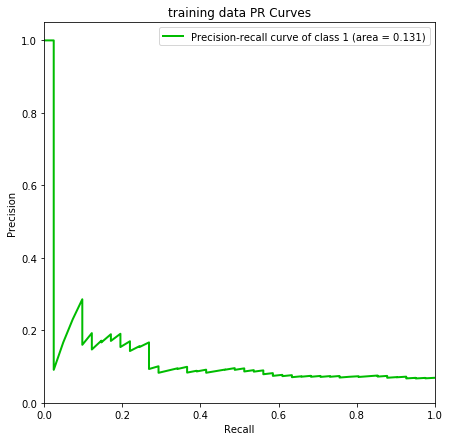

In [70]:
trainPredProb=NBclf2.predict_proba(Xtrain)
skplt.metrics.plot_precision_recall(ytrain, trainPredProb,
        plot_micro=False,
        figsize=(7,7),
        classes_to_plot=1,
        title='training data PR Curves');

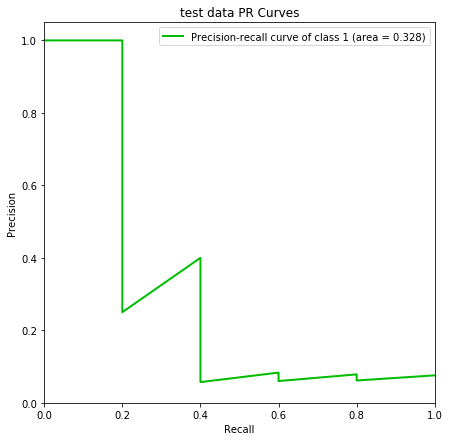

In [71]:
testPredProb=NBclf2.predict_proba(Xtest)
skplt.metrics.plot_precision_recall(ytest, testPredProb,
        plot_micro=False,
        figsize=(7,7),
        classes_to_plot=1,
        title='test data PR Curves');

# Another UDU 4U: Idiot Bayes With More Features

See if you can improve the model performances, above, by using more features.